In [1]:
import snap
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import leidenalg 
import igraph as ig
import networkx as nx
from collections import defaultdict
sys.path.append('../')
from src.util_data import loadNodeAttr
from src.util import getInletIds, getOutletIds, get_pos
sys.path.append('../src/data_cleaning/snair')
from clean_am import *
import json
import networkx.algorithms

In [2]:
G_LS174T = nx.read_edgelist("../data/Edgelist_v2/LS174T_clean_EdgesList.txt", nodetype=int)
G_SW1222 = nx.read_edgelist('../data/Edgelist_v2/SW1222_clean_EdgesList.txt', nodetype=int)
G_Mes = nx.read_edgelist('../data/Edgelist_v2/Mesentery_clean_EdgeList.txt', nodetype=int)

In [112]:
# part_LS = nx.algorithms.community.greedy_modularity_communities(G_LS174T)
part_SW = nx.algorithms.community.greedy_modularity_communities(G_SW1222)
# part_Mes = nx.algorithms.community.greedy_modularity_communities(G_Mes)

In [104]:
G_Mes = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/Mesentery_clean_EdgeList.txt", 0, 1, ' ')
nidx2clust_m = {}
total = set()
print G_Mes.GetNodes()
for i,x in enumerate(part_Mes):
    for y in x:
#         print y
        if G_Mes.IsNode(y):
            total.add(y)
            nidx2clust_m[y] = i
# print(set(range(G_LS174T.GetNodes())) - total)
unique, counts = np.unique(nidx2clust_m.values(), return_counts = True)
print "Number of communities = %d, largest community = %d"%(len(unique), np.amax(counts))
clusters_m = []
for i in range(388):
    if i in nidx2clust_m:
        clusters_m.append(nidx2clust_m[i]+1)
    else:
        clusters_m.append(0)
np.savetxt('M_communities.txt',np.asarray(clusters_m), delimiter='\n')

388
Number of communities = 15, largest community = 40


In [3]:
G_M = nx.read_edgelist("../data/Edgelist_v2/Mesentery_clean_EdgeList.txt", nodetype=int)
# LS174T_pos = get_pos('../data/og_files/LS174T_spatialGraph_RIN.txt')
# print(LS174T_pos)
m_coords = get_pos('m_coordinates.txt', small = True)
nx.draw(G_M, node_color=np.asarray(nidx2clust_m.values()), pos = m_coords, node_size=50, cmap=plt.cm.Paired)
plt.savefig('../figs/Mes_clustering.pdf')

NameError: name 'nidx2clust_m' is not defined

Save communities in dictionary for LS174T

In [115]:
G_LS174T = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/LS174T_clean_EdgesList.txt", 0, 1, '\t')
nidx2clust_LS = {}
total = set()
for i,x in enumerate(part_LS):
    for y in x:
        if G_LS174T.IsNode(y):
            total.add(y)
            nidx2clust_LS[y] = i
# print(set(range(G_LS174T.GetNodes())) - total)
unique, counts = np.unique(nidx2clust_LS.values(), return_counts = True)
print "Number of communities = %d, largest community = %d"%(len(unique), np.amax(counts))

Number of communities = 157, largest community = 673


In [116]:
community_LS = defaultdict(set)
for node, community in nidx2clust_LS.items():
    community_LS[community].add(node)
community_LS = dict(community_LS)

In [128]:
G_LS=nx.DiGraph()
G_LS.add_nodes_from(community_LS.keys())
for community, nodes in community_LS.items():
    nbrs = set()
    for node in nodes:
        node_nbr = [nbrs.add(nbr) for nbr in G_LS174T.GetNI(node).GetOutEdges()]
    for community2, nodes2 in community_LS.items():
        if community == community2:
            continue
        if nodes2 &nbrs:
            G_LS.add_edge(community, community2)
community_sizes = [len(val) for val in community_LS.values()]
community_colors = np.arange(len(community_sizes))
community_colors[community_sizes==1] = 1000
community_position = []
coordinates = get_pos('../data/og_files/LS174T_spatialGraph_RIN.txt')
community_coordinates = {}
for community, nodes in community_LS.items():
    sum_coord = np.asarray([0,0]).astype(np.float64)
    for node in nodes:
        sum_coord += coordinates[node]
    community_coordinates[community] = sum_coord[:2]/float(len(nodes))
print np.argsort(community_sizes)
print np.argmax(np.asarray(community_sizes)==22)

[156 129 128 127 126 125 124 123 122 121 130 120 118 116 115 114 113 112
 111 110 109 119 131 117 133 132 154 153 152 151 150 149 148 147 146 145
 155 143 142 141 140 139 138 137 136 135 144 134  95  94  93  92  87  90
  89  88  86  91  96  98  99  97 107 106 104 108 102 101 100 103 105  79
  85  84  83  82  81  80  78  76  77  74  71  75  73  72  70  69  68  67
  66  65  64  63  62  61  60  59  58  56  57  55  54  53  52  51  50  49
  48  47  46  45  44  43  42  41  40  39  38  37  36  35  34  33  32  31
  30  29  28  27  26  25  24  23  22  21  20  19  18  17  16  15  14  13
  12  11  10   9   8   7   6   5   4   3   2   1   0]
56


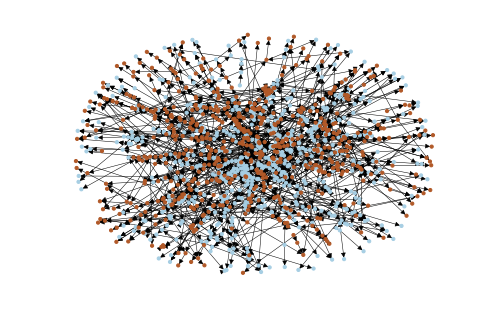

In [130]:
G_LS174T = nx.read_edgelist("../data/Edgelist_v2/LS174T_clean_EdgesList.txt", nodetype=int, create_using=nx.DiGraph)
count = 0
community_nodes = set()
labels = []
for community, nodes in community_LS.items():
    count+=1
    [community_nodes.add(node) for node in nodes]
    labels.extend([community]*len(nodes))
    if count==2:
        break
# for community in communities:
#     print(community)
subgraph = G_LS174T.subgraph(community_nodes)
nx.draw(subgraph, node_color=labels, cmap = plt.cm.Paired, width = 0.5, node_size=10)


# test = ig.Graph()

# test.add_vertices(10)
# test.add_edges([(0,1),(1,2), (0,3),  (3,4), (0,5), (5,6), (6,7), (5,8), (8,9)])
# part_test = leidenalg.find_partition(test, leidenalg.ModularityVertexPartition)
# print part_test

# nx.draw(test, cmap = plt.cm.Paired, width = 0.5, node_size=10)


843
1732


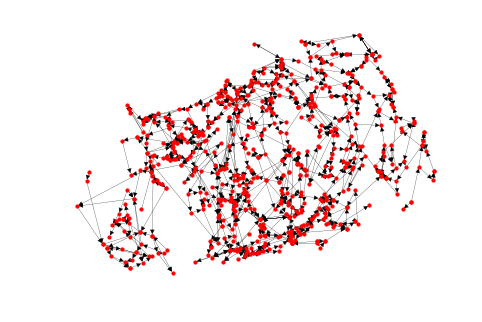

In [131]:
subgraph_LS = G_LS174T.subgraph(list(communities[0]))
G_LS174T = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/LS174T_clean_EdgesList.txt", 0, 1, '\t')
print(len(subgraph_LS.edges()))
total_degree= 0
for node in subgraph_LS.nodes():
    total_degree+=G_LS174T.GetNI(node).GetDeg()
print(total_degree)
LS174T_pos = get_pos('../data/og_files/LS174T_spatialGraph_RIN.txt')
nx.draw(subgraph_LS, cmap = plt.cm.Paired, pos = LS174T_pos, width = 0.25, node_size=10)
plt.savefig('../figs/LS_largest_community.pdf')

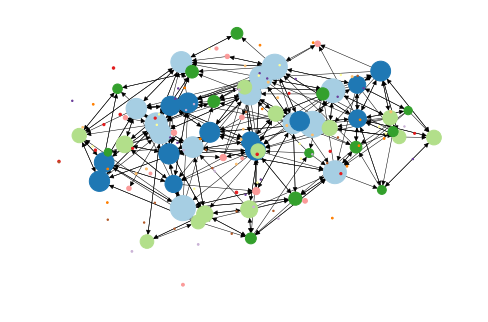

In [132]:
nx.draw(G_LS, node_color=community_colors, pos = community_coordinates, node_size=community_sizes, cmap=plt.cm.Paired, width = 0.5)
plt.savefig('../figs/LS_community_contraction.pdf')

In [106]:
G_SW1222 = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/SW1222_clean_EdgesList.txt", 0, 1, '\t')
nidx2clust_SW = {}
total = set()
for i,x in enumerate(part_SW):
    for y in x:
        if G_SW1222.IsNode(y):
            total.add(y)
            nidx2clust_SW[y] = i
# print(set(range(G_LS174T.GetNodes())) - total)
unique, counts = np.unique(nidx2clust_SW.values(), return_counts = True)
print "Number of communities = %d, largest community = %d"%(len(unique), np.amax(counts))

Number of communities = 1012, largest community = 1420


In [107]:
community_SW = defaultdict(set)
for node, community in nidx2clust_SW.items():
    community_SW[node].add(i)
community_SW = dict(community_SW)

In [83]:
G_SW=nx.Graph()
G_SW.add_nodes_from(community_SW.keys())
for community, nodes in community_SW.items():
    nbrs = set()
    for node in nodes:
        node_nbr = [nbrs.add(nbr) for nbr in G_SW1222.GetNI(node).GetOutEdges()]
    for community2, nodes2 in community_SW.items():
        if community == community2:
            continue
        if nodes2 &nbrs:
            G_SW.add_edge(community, community2)
community_sizes = [len(val) for val in community_LS.values()]
community_colors = np.arange(len(community_sizes))
community_colors[community_sizes==1] = 1000
community_position = []
coordinates = get_pos('../data/og_files/SW1222_spatialGraph_RIN.txt')
community_coordinates = {}
for community, nodes in community_SW.items():
    sum_coord = np.asarray([0,0,0]).astype(np.float64)
    for node in nodes:
        sum_coord += coordinates[node]
    community_coordinates[community] = sum_coord[:2]/float(len(nodes))
print community_coordinates[0]

KeyboardInterrupt: 

608
1462


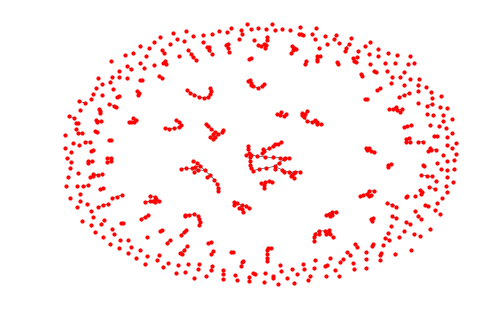

In [109]:
G_SW1222 = nx.read_edgelist("../data/Edgelist_v2/SW1222_clean_EdgesList.txt", nodetype=int)
subgraph_SW = G_SW1222.subgraph(list(communities[0]))
G_SW1222 = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist_v2/SW1222_clean_EdgesList.txt", 0, 1, '\t')
print(len(subgraph_SW.edges()))
total_degree= 0
for node in subgraph_SW.nodes():
    total_degree+=G_SW1222.GetNI(node).GetDeg()
print(total_degree)
nx.draw(subgraph_SW, cmap = plt.cm.Paired, width = 0.5, node_size=10)

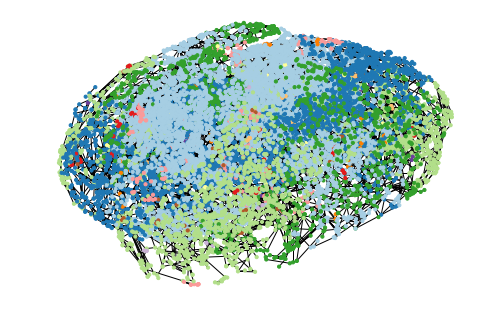

In [100]:
G_LS174T_nx = nx.read_edgelist("../data/Edgelist_v2/LS174T_clean_EdgesList.txt", nodetype=int)
LS174T_pos = get_pos('../data/og_files/LS174T_spatialGraph_RIN.txt')
# print(LS174T_pos)
nx.draw(G_LS174T_nx, node_color=np.asarray(nidx2clust_LS.values()), pos = LS174T_pos, node_size=10, cmap=plt.cm.Paired)
plt.savefig('../figs/LS_clustering.pdf')

In [10]:
clusters_LS = []
for i in range(18093):
    if i in nidx2clust_LS:
        clusters_LS.append(nidx2clust_LS[i]+1)
    else:
        clusters_LS.append(0)
clusters_SW = []
for i in range(72084):
    if i in nidx2clust_SW:
        clusters_SW.append(nidx2clust_SW[i]+1)
    else:
        clusters_SW.append(0)
np.savetxt('SW_communities.txt',np.asarray(clusters_SW), delimiter='\n')
np.savetxt('LS_communities.txt',np.asarray(clusters_LS), delimiter='\n')

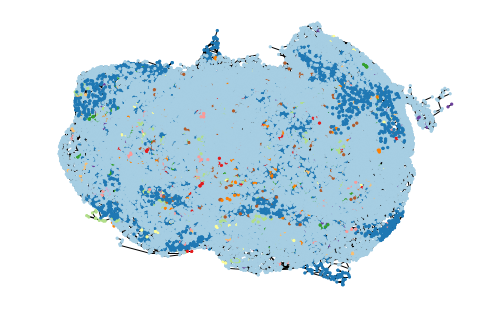

In [99]:
G_SW1222_nx = nx.read_edgelist("../data/Edgelist_v2/SW1222_clean_EdgesList.txt", nodetype=int)
SW1222_pos = get_pos('../data/og_files/SW122_spatialGraph_RIN.txt')
# print(LS174T_pos)
nx.draw(G_SW1222_nx, node_color=np.asarray(nidx2clust_SW.values()), pos = SW1222_pos, node_size=5, cmap=plt.cm.Paired)
plt.savefig('../figs/SW_clustering.pdf')

In [9]:
np.savetxt('LS_communities.txt', nidx2clust_LS, delimiter = ' ')
np.savetxt('SW_communities.txt', nidx2clust_SW, delimiter = ' ')

In [37]:
radii_SW = loadNodeAttr('../data/og_files/SW122_spatialGraph_RIN.txt')
radii_LS = loadNodeAttr('../data/og_files/LS174T_spatialGraph_RIN.txt')
pressure_SW = loadNodeAttr('../data/og_files/SW122_spatialGraph_RIN.txt', attr = 'pressure')
pressure_LS = loadNodeAttr('../data/og_files/LS174T_spatialGraph_RIN.txt', attr = 'pressure')
flow_SW = loadNodeAttr('../data/og_files/SW122_spatialGraph_RIN.txt', attr = 'flow')
flow_LS = loadNodeAttr('../data/og_files/LS174T_spatialGraph_RIN.txt', attr = 'flow')

In [8]:
#Check flow consistency
G_LS174T = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist/LS174T_clean_EdgesList.txt", 0, 1, '\t')
G_SW1222 = snap.LoadEdgeList(snap.PNGraph, "../data/Edgelist/SW1222_clean_EdgesList.txt", 0, 1, '\t')
inlets_LS = getInletIds(G_LS174T)
inlets_SW = getInletIds(G_SW1222)
outlets_LS = getOutletIds(G_LS174T)
outlets_SW = getOutletIds(G_SW1222)
inlet_flow_LS = [flow_LS[inlet] for inlet in inlets_LS]
outlet_flow_LS = [flow_LS[outlet] for outlet in outlets_LS]
inlet_flow_SW = [flow_SW[inlet] for inlet in inlets_SW]
outlet_flow_SW = [flow_SW[outlet] for outlet in outlets_SW]

print np.sum(inlet_flow_LS)
print np.sum(outlet_flow_LS)
print np.sum(inlet_flow_SW)
print np.sum(outlet_flow_SW)

39489.88763162267
40710.2160796772
842943.4201301008
855436.2396368664


In [87]:
community_radii_LS = defaultdict(list)
for node,cluster in nidx2clust_LS.items():
    community_radii_LS[cluster].append(radii_LS[node])

In [88]:
community_flow_LS = defaultdict(list)
for node,cluster in nidx2clust_LS.items():
    community_flow_LS[cluster].append(flow_LS[node])

In [89]:
community_pressure_LS = defaultdict(list)
for node,cluster in nidx2clust_LS.items():
    community_pressure_LS[cluster].append(pressure_LS[node])

In [90]:
community_radii_SW = defaultdict(list)
for node,cluster in nidx2clust_SW.items():
    community_radii_SW[cluster].append(radii_SW[node])

In [91]:
community_flow_SW = defaultdict(list)
for node,cluster in nidx2clust_SW.items():
    community_flow_SW[cluster].append(flow_SW[node])

In [92]:
community_pressure_SW = defaultdict(list)
for node,cluster in nidx2clust_SW.items():
    community_pressure_SW[cluster].append(pressure_SW[node])

[]

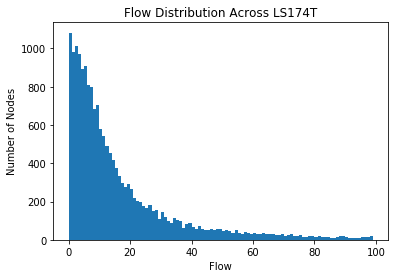

In [93]:
plt.hist(flow_LS.values(), bins = np.arange(0,100,1))
plt.xlabel('Flow')
plt.ylabel('Number of Nodes')
plt.title('Flow Distribution Across LS174T')
plt.plot()

[]

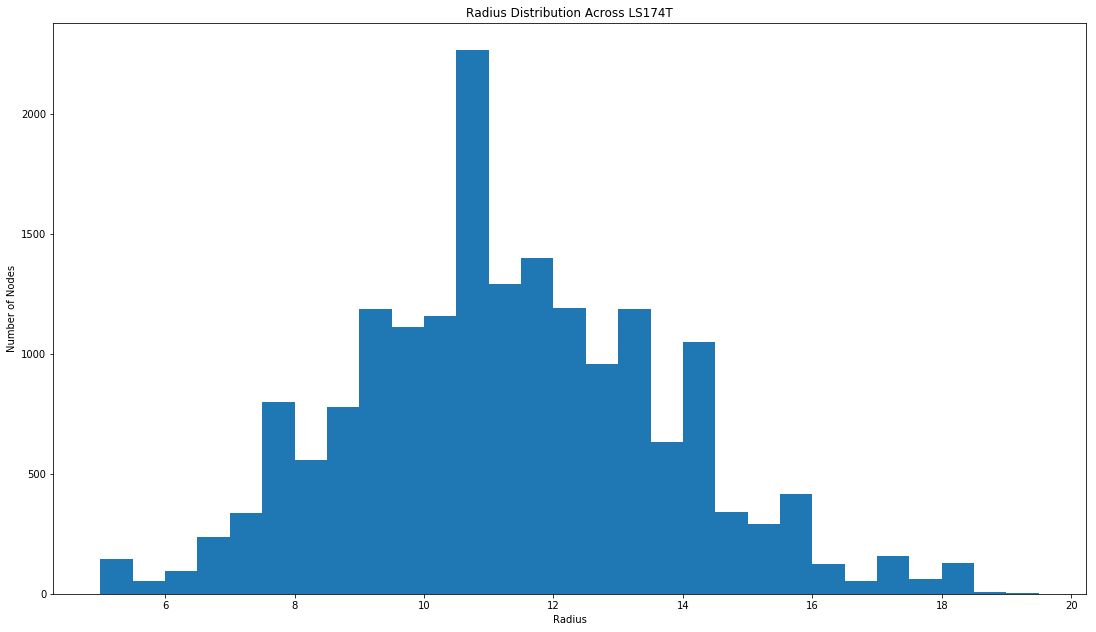

In [94]:
plt.hist(radii_LS.values(), bins = np.arange(5,20,0.5))
plt.gcf().set_size_inches(18.5, 10.5)
plt.xlabel('Radius')
plt.ylabel('Number of Nodes')
plt.title('Radius Distribution Across LS174T')
plt.plot()

[]

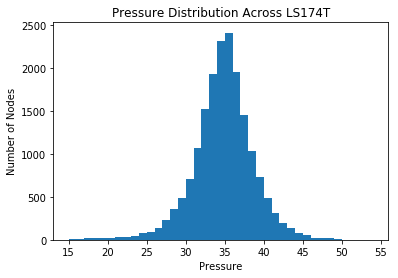

In [95]:
plt.hist(pressure_LS.values(), bins = np.arange(15,55,1))
plt.xlabel('Pressure')
plt.ylabel('Number of Nodes')
plt.title('Pressure Distribution Across LS174T')
plt.plot()

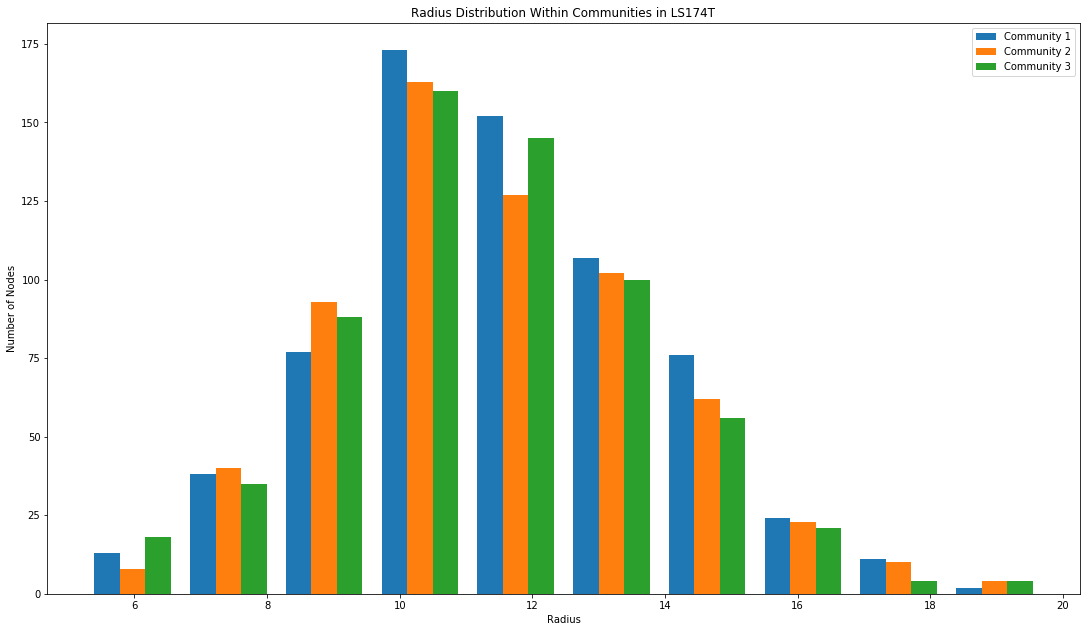

In [96]:
plt.hist(community_radii_LS.values()[:3], label=['Community 1', 'Community 2', 'Community 3'])
plt.xlabel('Radius')
plt.ylabel('Number of Nodes')
plt.title('Radius Distribution Within Communities in LS174T')
plt.legend()
plt.gcf().set_size_inches(18.5, 10.5)

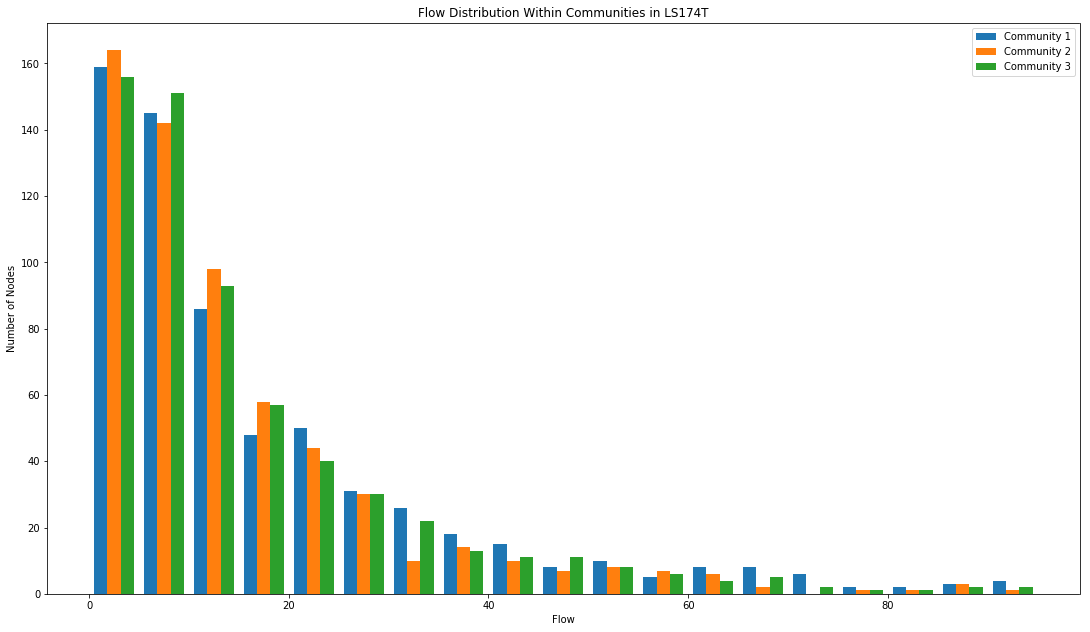

In [97]:
plt.hist(community_flow_LS.values()[:3], bins = np.arange(0,100,5), label=['Community 1', 'Community 2', 'Community 3'])
# plt.gca().set_xscale('log')
# plt.gcf().set_size_inches(18.5, 10.5)
plt.xlabel('Flow')
plt.ylabel('Number of Nodes')
plt.title('Flow Distribution Within Communities in LS174T')
plt.legend()
plt.gcf().set_size_inches(18.5, 10.5)

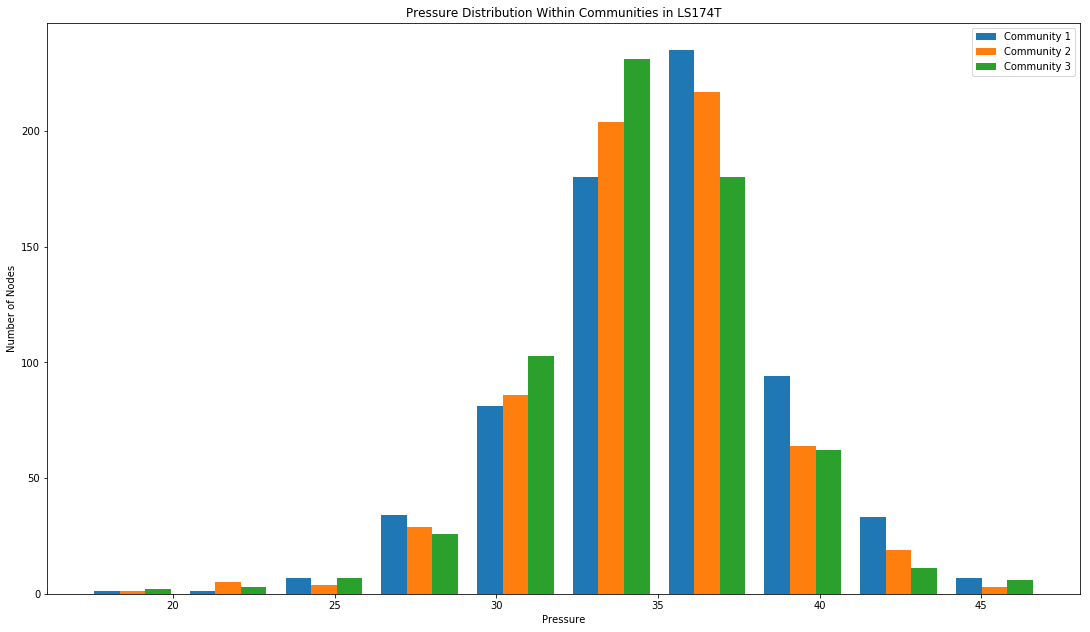

In [98]:
plt.hist(community_pressure_LS.values()[:3], label=['Community 1', 'Community 2', 'Community 3'])
# plt.gca().set_xscale('log')
# plt.gcf().set_size_inches(18.5, 10.5)
plt.xlabel('Pressure')
plt.ylabel('Number of Nodes')
plt.title('Pressure Distribution Within Communities in LS174T')
plt.legend()
plt.gcf().set_size_inches(18.5, 10.5)